<a href="https://colab.research.google.com/github/2813/ODS-homework/blob/main/04_ODS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Деревья решений**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Код для получения пути к файлам в Kaggle

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [ ]:
%pip install numpy==1.26.4 pandas==2.1.4 scikit-learn==1.7.0 matplotlib==3.8.0 graphviz == 0.21

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [ ]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'matplotlib': '3.8.0',
    'graphviz': '0.21'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status}')

print('\nРезультат проверки: ',
      '✓\nВсе версии соответствуют требованиям'
      if environment_ok else
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.12.12      | x (требуется 3.11.x)
numpy           | 1.26.4       | 2.0.2        | x (требуется 1.26.4)
pandas          | 2.1.4        | 2.2.2        | x (требуется 2.1.4)
scikit-learn    | 1.7.0        | 1.6.1        | x (требуется 1.7.0)
matplotlib      | 3.8.0        | 3.10.0       | x (требуется 3.8.0)
graphviz        | 0.21         | 0.21         | ✓

Результат проверки:  x
ВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!
Для решения проблемы обратитесь к инструкции по настройке виртуального окружения


## **Импорт библиотек и вспомогательные функции**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import graphviz

from sklearn import tree
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
RANDOM_STATE = 42

In [ ]:
def metrics_report(y_true, y_pred):
    """
    Выводит отчёт с основными метриками качества регрессии.
    Округляет до 4-х знаков после запятой и выводит значения R2 (коэффициент детерминации), RMSE (среднеквадратичная ошибка) и MAPE (средняя абсолютная процентная ошибка) для оценки качества предсказаний.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
    """
    print(f'R2 score: {r2_score(y_true, y_pred):.4f}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5:.4f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}')

## **Практическая часть**

### **Определения**

* **Дерево решений** — это модель, построенная на основе решающих правил вида «если, то», упорядоченных в древовидную иерархическую структуру.

* **Узел** (node) — это элемент дерева, который может быть либо внутренним (с условием проверки признака), либо листом (с конечным решением).

* **Внутренний узел** — это элемент дерева, который выполняет проверку значений признаков и направляет объекты к подузлам в зависимости от результата проверки.

* **Лист** (leaf) — это терминальный узел дерева, принимающий решение, то есть присваивающий объекту конечную метку класса (в задачах классификации) или значение целевой переменной (в задачах регрессии).

* **Глубина дерева** — это максимальное число ребер (уровней), которые необходимо пройти, начиная от корневого узла до самого глубокого листового узла.

### **Деревья решений в задаче классификации**

В рамках задачи классификации дерево решений рекурсивно разбивает данные на подмножества, стремясь максимизировать "чистоту" узлов, то есть стремясь к ситуации, когда в каждом узле дерева преобладают объекты одного класса.

Один из основных способов оценки качества разбиения — **индекс (критерий) Джини (Gini impurity)**, измеряющий вероятность ошибки, если случайно классифицировать объект в узле согласно распределению классов. Чем ниже значение индекса Джини, тем чище множество (лучше разделение).

Формула индекса Джини:

$$\text{G}=1-\sum_{i=1}^{k}{p^{2}_{i}}$$

где $k$ — количество классов, $p_{i}$ — доля объектов класса $i$ в узле.

Еще одним критерием для оценки разбиения является энтропия:

$$\text{H}=-\sum_{i=1}^{k}{p_{i}\log p_{i}}$$

Энтропия измеряет степень неопределенности в распределении классов. Энтропия равна нулю, если узел "чистый" (все объекты в узле относятся к одному классу), и достигает максимума, если классы распределены равномерно.

Оба критерия имеют схожие свойства и часто приводят к похожим результатам, но энтропия сильнее штрафует не однородные узлы. На практике выбор между критериями зависит от конкретной задачи и данных.

### ***Задание 1***

Сгенерируйте набор данных с двумя классами и двумя признаками с помощью [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) (см. код).

Реализуйте два простейших дерева решений, дополнив функции one_rule_tree_predict и two_rules_tree_predict:

* Дерево с одним узлом (функция one_rule_tree_predict):

    * если $x_1 \le -0.5$, то 0

    * иначе: 1

* Дерево с двумя узлами (функция two_rules_tree_predict):

    * если $x_1 \le -0.5$, то 0

    * иначе:
    
        * если $x_2 \le 0$, то 1
        
        * иначе: 0

Дополните класс CustomDecisionTreeClassifier, добавив недостающий код там, где это необходимо.

Обучите два дерева решений **c максимальной глубиной 3** на всем наборе данных:

* `tree_custom` — дерево CustomDecisionTreeClassifier.

* `tree_sk` — дерево DecisionTreeClassifier из библиотеки sklearn.

Для каждого из деревьев решений, включая простейшие деревья в виде функций (one_rule_tree_predict, two_rules_tree_predict, `tree_custom`, `tree_sk`), постройте отчёт по метрикам классификации.

In [ ]:
def display_decision_boundary(classifier, features, labels):
    """
    Визуализирует границу решений классификатора на двумерных данных.

    Аргументы:
        classifier (callable): Функция или метод модели, принимающий таблицу с признаками и возвращающий предсказанные классы.
        features (pandas.DataFrame): Двумерная таблица с признаками (только два признака), по которым строится визуализация.
        labels (numpy.ndarray): Массив меток классов.
    """
    x1_min, x1_max = features.iloc[:, 0].min() - 1, features.iloc[:, 0].max() + 1
    x2_min, x2_max = features.iloc[:, 1].min() - 1, features.iloc[:, 1].max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    decision = classifier(pd.DataFrame(np.c_[x1x1.ravel(), x2x2.ravel()], columns=features.columns)).reshape(x1x1.shape)
    plt.contourf(x1x1, x2x2, decision, alpha=0.5)
    plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, edgecolors='k')
    plt.show()

In [ ]:
# Сгенерируйте набор данных с двумя классами и двумя признаками с помощью make_moons

features, labels = datasets.make_moons(n_samples=200, noise=0.15, random_state=RANDOM_STATE)
features = pd.DataFrame(features)
features.columns = ['x1', 'x2']

In [ ]:
# В features два признака: x1 и x2

features

,x1,x2
0,-1.078161,0.063368
1,0.939809,0.457119
2,0.695151,0.642107
3,1.150173,-0.347871
4,0.249173,-0.068544
...,...,...
195,-0.039215,0.248731
196,0.778639,0.348020
197,-1.350844,0.323007
198,1.863808,-0.105644


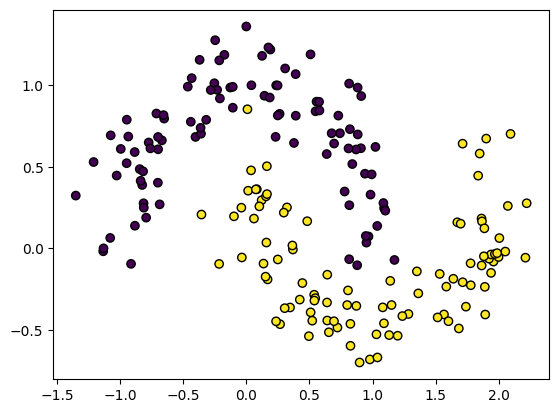

In [ ]:
# Визуализируйте датасет

plt.scatter(features['x1'], features['x2'], c=labels, edgecolors='k')
plt.show()

In [ ]:
# Дополните функцию one_rule_tree_predict

def one_rule_tree_predict(features):
    """
    Реализация предсказаний простейшего дерева решений с одним узлом:
        если x1 <= -0.5, то 0
        иначе: 1

    Аргументы:
        features (pandas.DataFrame): Таблица с входными признаками.

    Возвращает:
        numpy.ndarray: Массив предсказанных меток классов.
    """
    return np.where(features.iloc[:, 0] <= -0.5, 0, 1)

In [ ]:
# Постройте отчет по метрикам классификации для one_rule_tree_predict на всем наборе данных

print(classification_report(labels, one_rule_tree_predict(features)))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47       100
           1       0.59      1.00      0.74       100

    accuracy                           0.66       200
   macro avg       0.80      0.66      0.61       200
weighted avg       0.80      0.66      0.61       200



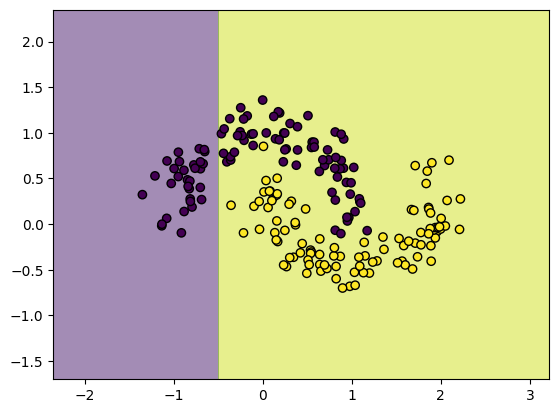

In [ ]:
# Визуализируйте границу решений классификатора one_rule_tree_predict на всем наборе данных

display_decision_boundary(one_rule_tree_predict, features, labels)

In [ ]:
# Дополните функцию two_rules_tree_predict

def two_rules_tree_predict(features):
    """
    Реализация предсказаний простейшего дерева решений с двумя узлами:
        если x1 <= -0.5, то 0т
        иначе:
            если x2 <= 0, то 1
            иначе: 0

    Аргументы:
        features (pandas.DataFrame): Таблица с входными признаками.

    Возвращает:
        numpy.ndarray: Массив предсказанных меток классов.
    """
    return np.where(features.iloc[:,0]<=-0.5, 0,
           np.where(features.iloc[:,1]<=0, 1, 0))

In [ ]:
# Постройте отчет по метрикам классификации для two_rules_tree_predict на всем наборе данных

print(classification_report(labels, two_rules_tree_predict(features)))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       100
           1       0.96      0.68      0.80       100

    accuracy                           0.82       200
   macro avg       0.85      0.82      0.82       200
weighted avg       0.85      0.82      0.82       200



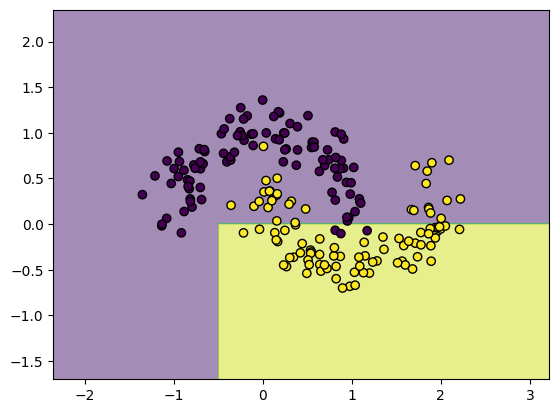

In [ ]:
# Визуализируйте границу решений классификатора two_rules_tree_predict на всем наборе данных

display_decision_boundary(two_rules_tree_predict, features, labels)

In [ ]:
# Дополните класс CustomDecisionTreeClassifier
# Код методов plot_node, plot_tree и count_nodes изменять не нужно

class CustomDecisionTreeClassifier():
    """
    Простой классификатор на основе дерева решений с критерием Джини в качестве критерия разделения.

    Аргументы:
        max_depth (int): Максимальная глубина дерева. По умолчанию — 3.

    Атрибуты:
        label (int): Метка класса, который наиболее часто встречается в узле.
        feature (str): Признак, используемый для разделения.
        size (int): Количество объектов в узле.
        threshold (float): Пороговое значение для разделения.
        left (CustomDecisionTreeClassifier): Левое поддерево (значение <= порог).
        right (CustomDecisionTreeClassifier): Правое поддерево (значение > порог).
        gini (float): Индекс Джини в узле.
    """
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.label = None
        self.feature = None
        self.size = None
        self.threshold = np.nan
        self.left = None
        self.right = None
        self.gini = 0

    def gini_impurity(self, y):
        """
        Вычисляет индекс Джини для массива меток классов.

        Аргументы:
            y (numpy.ndarray): Массив меток классов.

        Возвращает:
            float: Значение индекса Джини.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities**2)

    def best_split(self, X, y):
        """
        Находит оптимальный признак и порог для разделения данных.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив меток классов.

        Возвращает:
            tuple:
                str: Оптимальный признак для разделения.
                float: Оптимальное пороговое значение.
                float: Значение индекса Джини после оптимального разделения.
        """
        best_feature = None
        best_threshold = None
        best_gini = self.gini_impurity(y)
        N = X.shape[0]
        for feature in X.columns:
            values = np.sort(X[feature].unique())
            thresholds = [(values[i] + values[i+1]) / 2 for i in range(len(values)-1)]
            for threshold in thresholds:
                mask_left = X[feature] <= threshold
                mask_right = ~mask_left
                N_left = np.sum(mask_left) # количество элементов в левом поддереве
                N_right = np.sum(mask_right)
                if N_left == 0 or N_right == 0:
                    continue
                gini_left = self.gini_impurity(y[mask_left])
                gini_right = self.gini_impurity(y[mask_right])
                weighted_gini = (N_left * gini_left + N_right * gini_right) / N
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gini

    def fit(self, X, y):
        """
        Обучает дерево решений, рекурсивно находя оптимальные разделения.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив меток классов.

        Возвращает:
            CustomDecisionTreeClassifier: Обученное дерево решений.
        """
        self.size = len(y)
        classes, counts = np.unique(y, return_counts=True)
        self.label = classes[np.argmax(counts)]
        self.gini = self.gini_impurity(y)
        if self.max_depth == 0:
            return
        self.feature, self.threshold, gini = self.best_split(X, y)
        if self.feature is None or gini >= self.gini:
            return
        self.gini = gini
        mask_left = X[self.feature] <= self.threshold
        mask_right = ~mask_left
        self.left = CustomDecisionTreeClassifier(max_depth=self.max_depth-1)
        self.right = CustomDecisionTreeClassifier(max_depth=self.max_depth-1)
        self.left.fit(X[mask_left], y[mask_left])
        self.right.fit(X[mask_right], y[mask_right])
        return self

    def predict(self, X):
        """
        Предсказывает метки классов.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.

        Возвращает:
            numpy.ndarray: Массив предсказанных меток классов.
        """
        if self.feature is None:
            return np.full(X.shape[0], self.label)
        mask_left = X[self.feature] <= self.threshold
        mask_right = ~mask_left
        y_pred = np.empty(X.shape[0])
        y_pred[mask_left] = self.left.predict(X[mask_left])
        y_pred[mask_right] = self.right.predict(X[mask_right])

        return y_pred

    def plot_node(self, dot, node_id=0):
        """
        Вспомогательный метод для визуализации дерева.

        Аргументы:
            dot (graphviz.Digraph): Объект Digraph библиотеки graphviz.
            node_id (int): Идентификатор текущего узла. По умолчанию — 0.

        Возвращает:
            int: Идентификатор узла.
        """
        if self.feature is None:
            label = f"gini = {self.gini:.3f}\nsamples = {self.size}\nlabel = {self.label}"
            dot.node(str(node_id), label=label, fillcolor="#8ccd96")
            return node_id
        label = f"{self.feature} <= {self.threshold:.3f}\ngini = {self.gini:.3f}\nsamples = {self.size}\nlabel = {self.label}"
        dot.node(str(node_id), label=label, fillcolor="#ffffff")
        left_id = self.left.plot_node(dot, node_id*2 + 1)
        dot.edge(str(node_id), str(left_id))
        right_id = self.right.plot_node(dot, node_id*2 + 2)
        dot.edge(str(node_id), str(right_id))

        return node_id

    def plot_tree(self, filled=True):
        """
        Генерирует визуализацию дерева решений.

        Аргументы:
            filled (bool): Закрашивать узлы. По умолчанию — True.

        Возвращает:
            graphviz.Digraph: Объект graphviz с визуализацией дерева.
        """
        dot = graphviz.Digraph()
        dot.attr('node', shape='box', style='filled' if filled else None)
        self.plot_node(dot)
        return dot

    def count_nodes(self):
        """
        Рассчитывает сложность дерева — совокупное количество узлов в дереве.

        Возвращает:
            int: Общее количество узлов.
        """
        if self.feature is None:
            return 1
        return 1 + self.left.count_nodes() + self.right.count_nodes()

In [ ]:
# Обучите дерево tree_custom (CustomDecisionTreeClassifier)
# Максимальная глубина — 3

tree_custom = CustomDecisionTreeClassifier(max_depth=3)
tree_custom.fit(features, labels)

In [ ]:
# Постройте отчет по метрикам классификации для tree_custom на всем наборе данных

print(classification_report(labels, tree_custom.predict(features)))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       100
           1       0.88      0.97      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



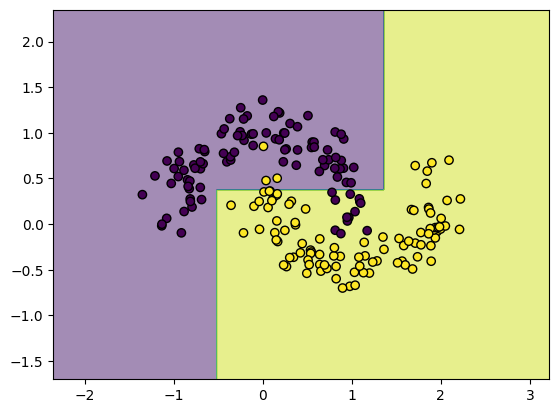

In [ ]:
# Визуализируйте границу решений классификатора tree_custom на всем наборе данных

display_decision_boundary(tree_custom.predict, features, labels)

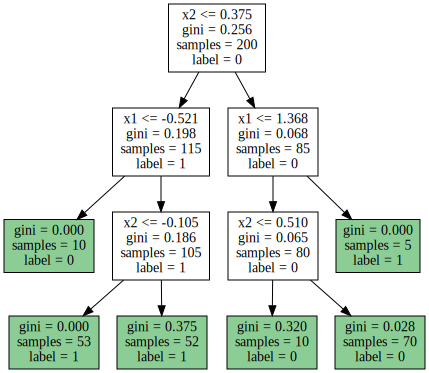

In [ ]:
# Визуализируйте дерево tree_custom

tree_custom.plot_tree()

In [ ]:
# Обучите дерево tree_sk (DecisionTreeClassifier)
# Максимальная глубина — 3
# Не забудьте зафиксировать RANDOM_STATE

tree_sk = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
tree_sk.fit(features, labels)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
# Постройте отчет по метрикам классификации для tree_sk на всем наборе данных

print(classification_report(labels, tree_sk.predict(features)))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       100
           1       0.88      0.97      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



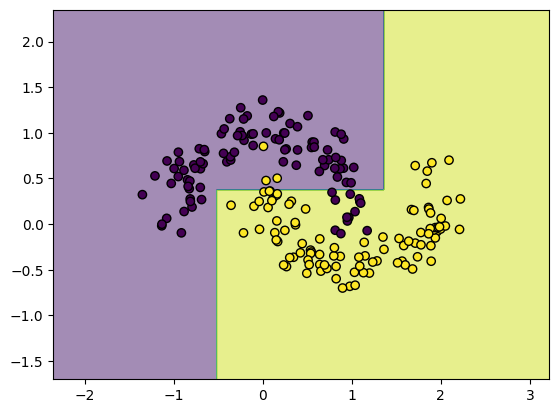

In [ ]:
# Визуализируйте границу решений классификатора tree_sk на всем наборе данных

display_decision_boundary(tree_sk.predict, features, labels)

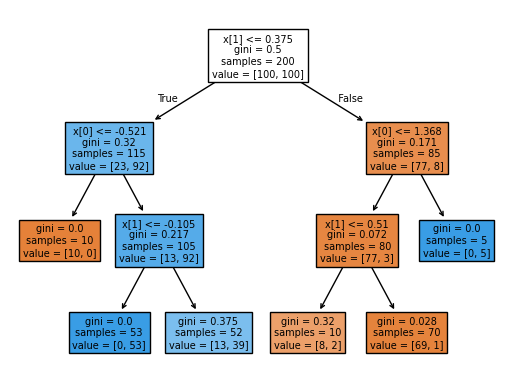

In [ ]:
# Визуализируйте дерево tree_sk

_ = plot_tree(tree_sk, filled=True)

### **Деревья решений: масштабирование признаков и обработка пропущенных значений**

Особенностью деревьев решений и основанных на них ансамблевых методов (случайный лес, градиентный бустинг) является их устойчивость к некоторым распространённым проблемам предобработки данных, которые являются критичными для многих других алгоритмов машинного обучения.

В частности, деревьям решений и ансамблевым методам, основанным на деревьях, не требуется масштабирование признаков, поскольку масштабирование не влияет на структуру дерева и на то, какие признаки будут выбраны для разделения и в каком порядке. Это связано с тем, что деревья решений строят свои правила разделения данных (сплиты) на основе пороговых значений для каждого признака, вне зависимости от его исходного масштаба.

Кроме того, деревья решений и их ансамбли, как правило, могут эффективно использовать данные с пропущенными значениями без явной предварительной их обработки. Это связано с их способностью адаптироваться к таким данным: различные реализации алгоритмов деревьев имеют встроенные механизмы для работы с пропущенными значениями:

* Создание отдельной ветви для пропущенных значений (XGBoost и LightGBM). Если признак используется для разделения, и для некоторых наблюдений его значение отсутствует, эти наблюдения направляются в отдельную ветвь.

* Направление в ветку с большинством наблюдений (DecisionTreeClassifier и DecisionTreeRegressor). Пропуски направляются в ту ветвь, которая содержит большинство наблюдений (или обеспечивает наилучшее качество сплита) из обучающего набора, для которых значение признака известно.

Тем не менее, методы обработки пропущенных значений для деревьев решений и ансамблевых методов могут быть полезны для некоторых сценариев. Например, для сравнения с другими моделями или для более глубокого анализа данных.

### **Методы борьбы с переобучением деревьев**

Существенный недостаток деревьев решений — **склонность к переобучению**, в частности при отсутствии ограничений на рост.

Переобучение дерева решений проявляется в чрезмерном ветвлении, чувствительности к данным и высокой дисперсии предсказаний: сложное дерево дает очень точные предсказания на обучающей выборке, но ошибается на тестовой.

**Основные методы борьбы с переобучением:**

* Подбор параметров дерева:

    * max_depth — максимальная глубина дерева.

    * min_samples_split — минимальное количество объектов для разбиения узла.

    * min_samples_leaf — минимальное количество объектов в листе.

* Прунинг (обрезка) дерева — удаление избыточных ветвей после построения дерева на основе их значимости **без учёта сложности дерева**.

* Cost-Complexity Pruning — это метод, суть которого состоит в нахождении **компромисса (баланса) между точностью модели и сложностью дерева**.
    
* Ансамблевые методы (будут рассмотрены в следующих темах курса):

    * Случайный лес (random forest) — усреднение предсказаний множества деревьев с разными подвыборками данных и признаков.

    * Градиентный бустинг (gradient boosting) — последовательное улучшение модели за счет добавления деревьев, исправляющих ошибки предыдущих.

### **Деревья решений в задаче регрессии**

Деревья решений могут также применяться для задачи регрессии. В отличие от классификации, где листья дерева содержат метки классов, в регрессии каждый лист возвращает числовое значение — среднее (или медиану) целевой переменной для объектов, попавших в этот лист.

При построении дерева разбиение выбирается так, чтобы максимально уменьшить функцию ошибки (MSE, MAE и др.) в дочерних узлах по сравнению с родительским.

### **Датасет *California Housing dataset***

**Для решения заданий 2 — 3 рассмотрим датасет [California Housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).**

Набор данных предназначен для прогнозирования медианной стоимости домов по районам штата Калифорния на основе агрегированных показателей. Датасет содержит 20640 наблюдений без пропущенных значений и сформирован на основе переписи населения США 1990 года с разбивкой по районам городов.

Целевая переменная — target (медианная стоимость домов в районе, выраженная в сотнях тысяч долларов).

Признаки:

* MedInc — медианный доход в районе.

* HouseAge — медианный возраст домов в районе.

* AveRooms — среднее количество комнат в домах района.

* AveBedrms — среднее количество спален в домах района.

* Population — численность населения в районе.

* AveOccup — среднее число членов домохозяйства в районе.

* Latitude — географическая широта района.

* Longitude — географическая долгота района.

### ***Задание 2***

Дополните класс CustomDecisionTreeRegressor (функция ошибки — MSE), добавив недостающий код, где это необходимо. В рамках класса CustomDecisionTreeRegressor необходимо также реализовать метод prune для рекурсивного прунинга (обрезки) дерева по следующему алгоритму:

* Рекурсивный обход дерева начинается с листьев и движется к корню дерева по узлам. Для каждого узла дерева:

    1. Вычисляется взвешенная ошибка дочерних узлов:

    $$\text{MSE}_{\text{weighted}}=\frac{N_{\text{left}}\times \text{MSE}_{\text{left}}+N_{\text{right}}\times \text{MSE}_{\text{right}}}{N_{\text{left}}+N_{\text{right}}}$$

    где $N_{\text{left}}$ и $N_{\text{right}}$ — количество объектов в дочерних узлах.

    2. Проверяется критерий обрезки — малое (меньше $\varepsilon$) улучшение ошибки родительского узла:

    $$\text{MSE}_{\text{parent}}-\text{MSE}_{\text{weighted}} < \varepsilon$$

    3. Если критерий выполняется (**улучшение $\text{MSE}$ меньше $\varepsilon$**), то поддерево можно удалить, заменив его листом.

Обучите дерево решений `tree_housing_custom` (CustomDecisionTreeRegressor) на обучающей выборке с максимальной глубиной 8.

Обучите аналогичное дерево решений `tree_housing_custom_pruned` (CustomDecisionTreeRegressor) на обучающей выборке с максимальной глубиной 8 и выполните его обрезку (прунинг) с помощью метода prune. В качестве порогового значения для обрезки используйте epsilon=0.02.

Выведите metrics_report для моделей `tree_housing_custom` и `tree_housing_custom_pruned` **на обучающей и тестовой выборке** и сравните сложности (совокупное количество улов в дереве) деревьев (метод count_nodes).

In [ ]:
# Загрузите набор данных с помощью sklearn.datasets и выделите объясняемый фактор в отдельную переменную

df_housing = datasets.fetch_california_housing()
X_housing = pd.DataFrame(df_housing.data)
X_housing.columns = df_housing.feature_names
X_housing = X_housing.sample(2000, random_state=RANDOM_STATE)   # Случайным образом выберем 2000 наблюдений
y_housing = df_housing.target[X_housing.index]

In [ ]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки
# Не забудьте зафиксировать RANDOM_STATE

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_housing, y_housing, test_size=0.4, random_state=RANDOM_STATE)

In [ ]:
# Дополните класс CustomDecisionTreeRegressor
# Код методов plot_node, plot_tree и count_nodes изменять не нужно

class CustomDecisionTreeRegressor():
    """
    Простой регрессор на основе дерева решений с ошибкой MSE в качестве критерия разделения и средним значением в листе для прогноза.

    Аргументы:
        max_depth (int): Максимальная глубина дерева. По умолчанию — 8.

    Атрибуты:
        value (float): Среднее значение целевой переменной в узле.
        feature (str): Признак, используемый для разделения.
        size (int): Количество объектов в узле.
        threshold (float): Пороговое значение для разделения.
        left (CustomDecisionTreeRegressor): Левое поддерево (значение <= порог).
        right (CustomDecisionTreeRegressor): Правое поддерево (значение > порог).
        mse (float): Ошибка MSE в узле.
    """
    def __init__(self, max_depth=8):
        self.max_depth = max_depth
        self.value = None
        self.feature = None
        self.size = None
        self.threshold = np.nan
        self.left = None
        self.right = None
        self.mse = 0


    def MSE(self, y_true, y_pred):
        """
        Вычисляет среднеквадратичную ошибку (MSE).

        Аргументы:
            y_true (numpy.ndarray): Массив истинных значений целевой переменной.
            y_pred (numpy.ndarray): Массив предсказанных значений целевой переменной.

        Возвращает:
            float: Значение MSE.
        """
        return np.mean((y_true - y_pred)**2)


    def best_split(self, X, y):
        """
        Находит оптимальный признак и порог для разделения данных.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив значений целевой переменной.

        Возвращает:
            tuple:
                str: Оптимальный признак для разделения.
                float: Оптимальное пороговое значение.
                float: Значение среднеквадратичной ошибки (MSE) после разделения.
        """
        best_feature = None
        best_threshold = None
        best_mse = self.MSE(y, y.mean())
        N = X.shape[0]
        for feature in X.columns:
            values = np.sort(X[feature].unique())
            thresholds = [(values[i] + values[i+1]) / 2 for i in range(len(values) - 1)]
            for threshold in thresholds:
                mask_left = X[feature] <=  threshold
                mask_right = ~mask_left
                N_left = np.sum(mask_left) # кол-во элементов в левом поддереве
                N_right = np.sum(mask_right)
                if N_left == 0 or N_right == 0:
                    continue
                loss_left = self.MSE(y[mask_left], y[mask_left].mean())
                loss_right = self.MSE(y[mask_right], y[mask_right].mean())
                # взвешенное MSE
                weighted_mse = (N_left * loss_left + N_right * loss_right)/(N_left + N_right)
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold, best_mse


    def fit(self, X, y):
        """
        Обучает дерево решений, рекурсивно находя оптимальные разделения.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив значений целевой переменной.

        Возвращает:
            CustomDecisionTreeRegressor: Обученное дерево решений.
        """
        self.value = y.mean()
        self.mse = self.MSE(y, self.value)
        self.size = len(y)
        if self.max_depth == 0:
            return
        self.feature, self.threshold, mse = self.best_split(X, y)
        if self.feature is None or mse >= self.mse:
            return
        self.mse = mse
        mask_left = X[self.feature] <= self.threshold
        mask_right = ~mask_left
        self.left = CustomDecisionTreeRegressor(max_depth=self.max_depth - 1)
        self.right = CustomDecisionTreeRegressor(max_depth=self.max_depth -1)
        self.left.fit(X[mask_left], y[mask_left])
        self.right.fit(X[mask_right], y[mask_right])
        return self

    def predict(self, X):
        """
        Предсказывает значения целевой переменной.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.

        Возвращает:
            numpy.ndarray: Массив предсказанных значений целевой переменной.
        """
        if self.feature is None:
            return np.full(X.shape[0], self.value)
        mask_left = X[self.feature] <= self.threshold
        mask_right = ~mask_left
        y_pred = np.empty(X.shape[0])
        y_pred[mask_left] = self.left.predict(X[mask_left])
        y_pred[mask_right] = self.right.predict(X[mask_right])
        return y_pred

    def prune(self, epsilon):
        """
        Обрезает дерево, если разница ошибок между родительским и дочерними узлами меньше epsilon.
        После обрезки внутренний узел становится листом.

        Аргументы:
            epsilon (float): Пороговое значение для обрезки.
        """
        if self.feature is None:
            return
        self.left.prune(epsilon)
        self.right.prune(epsilon)
        left_size = self.left.size
        right_size = self.right.size
        left_mse = self.left.mse
        right_mse = self.right.mse
        weighted_mse = (left_size * left_mse + right_size * right_mse)/(left_size + right_size)
        if weighted_mse > 0 and abs(self.mse - weighted_mse) < epsilon:
            self.feature = None
            self.threshold = np.nan
            self.left = None
            self.right = None

    def plot_node(self, dot, node_id=0):
        """
        Вспомогательный метод для визуализации дерева.

        Аргументы:
            dot (graphviz.Digraph): Объект Digraph библиотеки graphviz.
            node_id (int): Идентификатор текущего узла. По умолчанию — 0.

        Возвращает:
            int: Идентификатор узла.
        """
        if self.feature == None:
            dot.node(str(node_id), label='mse = {:.3f}\nsamples = {}\nvalue = {:.3f}'.format(self.mse, self.size, self.value), fillcolor="#8ccd96")
            return node_id
        dot.node(str(node_id), label='{} <= {:.3f}\nmse = {:.3f}\nsamples = {}\nvalue = {:.3f}'
                 .format(self.feature, self.threshold, self.mse, self.size, self.value), fillcolor="#ffffff")
        left_id = self.left.plot_node(dot, node_id*2 + 1)
        dot.edge(str(node_id), str(left_id))
        right_id = self.right.plot_node(dot, node_id*2 + 2)
        dot.edge(str(node_id), str(right_id))
        return node_id

    def plot_tree(self, filled=True):
        """
        Генерирует визуализацию дерева решений.

        Аргументы:
            filled (bool): Закрашивать узлы. По умолчанию — True.

        Возвращает:
            graphviz.Digraph: Объект graphviz с визуализацией дерева.
        """
        dot = graphviz.Digraph()
        dot.attr('node', shape='box', style='filled' if filled else None)
        self.plot_node(dot)
        return dot

    def count_nodes(self):
        """
        Рассчитывает сложность дерева — совокупное количество узлов в дереве.

        Возвращает:
            int: Общее количество узлов.
        """
        if self.feature is None:
            return 1
        return 1 + self.left.count_nodes() + self.right.count_nodes()

In [ ]:
# Обучите дерево tree_housing_custom (CustomDecisionTreeRegressor)
# Максимальная глубина — 8

tree_housing_custom = CustomDecisionTreeRegressor(max_depth=8)
tree_housing_custom.fit(X_housing_train, y_housing_train)

In [ ]:
# Выведите metrics_report для дерева tree_housing_custom на обучающей и тестовой выборках
print("="*8,"train","="*8)
metrics_report(y_housing_train, tree_housing_custom.predict(X_housing_train))
print("="*8,"test","="*8)
metrics_report(y_housing_test, tree_housing_custom.predict(X_housing_test))

======== train ========
R2 score: 0.8838
RMSE: 0.3898
MAPE: 0.1742
======== test ========
R2 score: 0.5386
RMSE: 0.7946
MAPE: 0.2965


In [ ]:
# Выведите сложность дерева tree_housing_custom

tree_housing_custom.count_nodes()

321

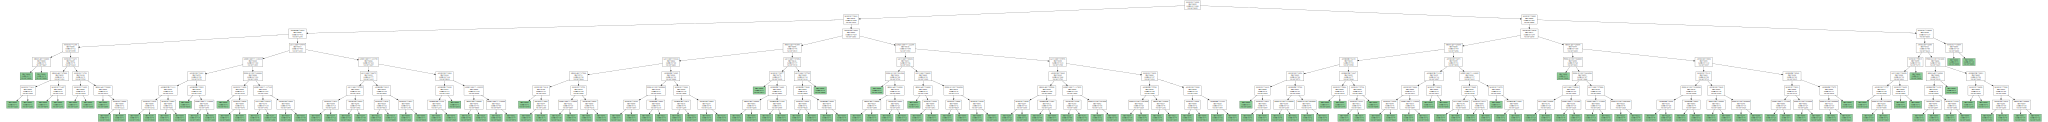

In [ ]:
# Визуализируйте дерево tree_housing_custom (не обязательно)

tree_housing_custom.plot_tree()

In [ ]:
# Обучите дерево tree_housing_custom_pruned (CustomDecisionTreeRegressor) и выполните его обрезку с помощью метода prune
# Максимальная глубина — 8
# epsilon=0.02

tree_housing_custom_pruned = CustomDecisionTreeRegressor(max_depth=8)
tree_housing_custom_pruned.fit(X_housing_train, y_housing_train)
tree_housing_custom_pruned.prune(epsilon=0.02)

In [ ]:
# Выведите metrics_report для дерева tree_housing_custom_pruned на обучающей и тестовой выборках
print(f'{"="*8} train {"="*8}')
metrics_report(y_housing_train, tree_housing_custom_pruned.predict(X_housing_train))
print(f'{"="*8} test {"="*8}')
metrics_report(y_housing_test, tree_housing_custom_pruned.predict(X_housing_test))

======== train ========
R2 score: 0.8289
RMSE: 0.4730
MAPE: 0.2170
======== test ========
R2 score: 0.5510
RMSE: 0.7839
MAPE: 0.2923


In [ ]:
# Выведите сложность дерева tree_housing_custom_pruned

tree_housing_custom_pruned.count_nodes()

193

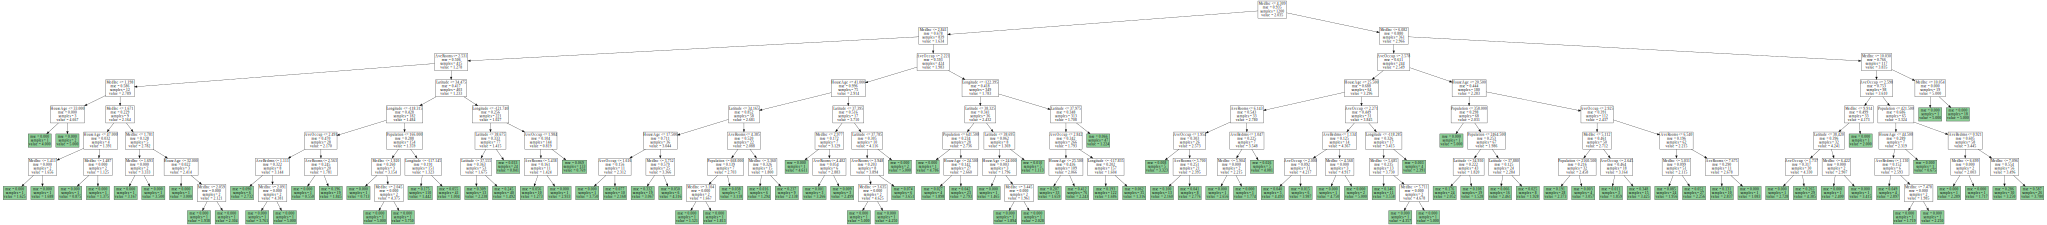

In [ ]:
# Визуализируйте дерево tree_housing_custom_pruned (не обязательно)

tree_housing_custom_pruned.plot_tree()

### **Cost-Complexity Pruning**

**Cost-Complexity Pruning** (CCP) — это метод борьбы с переобучением в деревьях решений, суть которого состоит в нахождении оптимального баланса между точностью модели и сложностью дерева.

Общий критерий оптимизации:

$$R_{\alpha}(T)=R(T)+\alpha|T|$$

где $R(T)$ — ошибка дерева (к примеру, MSE/MAE для регрессии или Gini/Entropy для классификации), $|T|$ — количество листьев в дереве, $\alpha$ — параметр регуляризации.

Cost-Complexity Pruning в sklearn для деревьев решений (DecisionTreeClassifier и DecisionTreeRegressor) реализуется с помощью **параметра ccp_alpha**.

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую и тестовую выборку из задания 2: `X_housing_train`, `X_housing_test`, `y_housing_train`, `y_housing_test`.

Обучите дерево решений `tree_housing` (DecisionTreeRegressor) без ограничений на глубину дерева.

С помощью модели `tree_housing` рассчитайте все возможные значения параметра ccp_alpha (`ccp_alphas`), используя метод [cost_complexity_pruning_path](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#post-pruning-decision-trees-with-cost-complexity-pruning).

Подберите оптимальное значение параметра ccp_alpha, перебрав все возможные значения `ccp_alphas` с помощью GridSearchCV.

Обучите дерево решений `tree_housing_ccp` (DecisionTreeRegressor) с оптимальным параметром ccp_alpha.

Выведите metrics_report для моделей `tree_housing` и `tree_housing_ccp` **на обучающей и тестовой выборке** и сравните сложности деревьев (метод count_nodes).

In [ ]:
# Обучите дерево tree_housing без ограничений
# Не забудьте зафиксировать RANDOM_STATE

tree_housing = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_housing.fit(X_housing_train, y_housing_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Выведите metrics_report для дерева tree_housing на обучающей и тестовой выборках

print(f'{"="*8} train {"="*8}')
metrics_report(y_housing_train, tree_housing.predict(X_housing_train))
print(f'{"="*8} test {"="*8}')
metrics_report(y_housing_test, tree_housing.predict(X_housing_test))

======== train ========
R2 score: 1.0000
RMSE: 0.0000
MAPE: 0.0000
======== test ========
R2 score: 0.4889
RMSE: 0.8364
MAPE: 0.3153


In [ ]:
# Посчитайте сложность дерева tree_housing

tree_housing.tree_.node_count

2335

In [ ]:
# С помощью tree_housing рассчитайте все возможные значения ccp_alpha, используя метод cost_complexity_pruning_path

ccp_alphas = tree_housing.cost_complexity_pruning_path(X_housing_train, y_housing_train).ccp_alphas

In [ ]:
# Получение пути обрезки по стоимости-сложности
path = tree_housing.cost_complexity_pruning_path(X_housing_train, y_housing_train)
ccp_alphas = path.ccp_alphas

# Обычно исключают последнее максимальное значение, так как оно соответствует дереву с одним узлом
ccp_alphas = ccp_alphas[:-1]

print(f"Количество ccp_alpha для перебора: {len(ccp_alphas)}")
print(f"Диапазон ccp_alpha: от {ccp_alphas[0]:.6f} до {ccp_alphas[-1]:.6f}")

Количество ccp_alpha для перебора: 1115
Диапазон ccp_alpha: от 0.000000 до 0.109047


In [ ]:
# Подберите оптимальное значение ccp_alpha с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'ccp_alpha': ccp_alphas}
scoring='neg_mean_squared_error'
cv = 5

cv_tree_housing_ccp = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid = params,
    scoring = scoring,
    cv = cv
).fit(X_housing_train, y_housing_train)

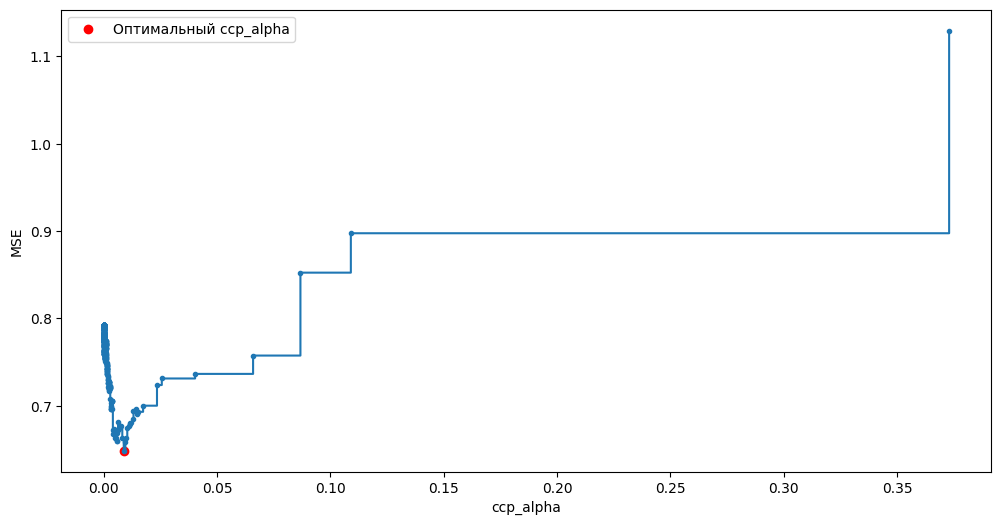

In [ ]:
# Постройте график MSE ~ ccp_alpha по результатам кросс-валидации

plt.figure(figsize=(12, 6))
plt.plot(ccp_alphas, -cv_tree_housing_ccp.cv_results_['mean_test_score'], marker='.', drawstyle='steps-post')
plt.scatter(cv_tree_housing_ccp.best_params_['ccp_alpha'], -cv_tree_housing_ccp.best_score_, c='red', label='Оптимальный ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# Обучите дерево tree_housing_ccp с оптимальным параметром ccp_alpha
# Не забудьте зафиксировать RANDOM_STATE

tree_housing_ccp = cv_tree_housing_ccp.best_estimator_.fit(X_housing_train, y_housing_train)

In [ ]:
# Выведите metrics_report для дерева tree_housing_ccp на обучающей и тестовой выборках

print(f'{"="*8} train {"="*8}')
metrics_report(y_housing_train, tree_housing_ccp.predict(X_housing_train))
print(f'{"="*8} test {"="*8}')
metrics_report(y_housing_test, tree_housing_ccp.predict(X_housing_test))

======== train ========
R2 score: 0.6785
RMSE: 0.6484
MAPE: 0.2895
======== test ========
R2 score: 0.5669
RMSE: 0.7699
MAPE: 0.3066


In [ ]:
# Посчитайте сложность дерева tree_housing_ccp

tree_housing_ccp.tree_.node_count

41

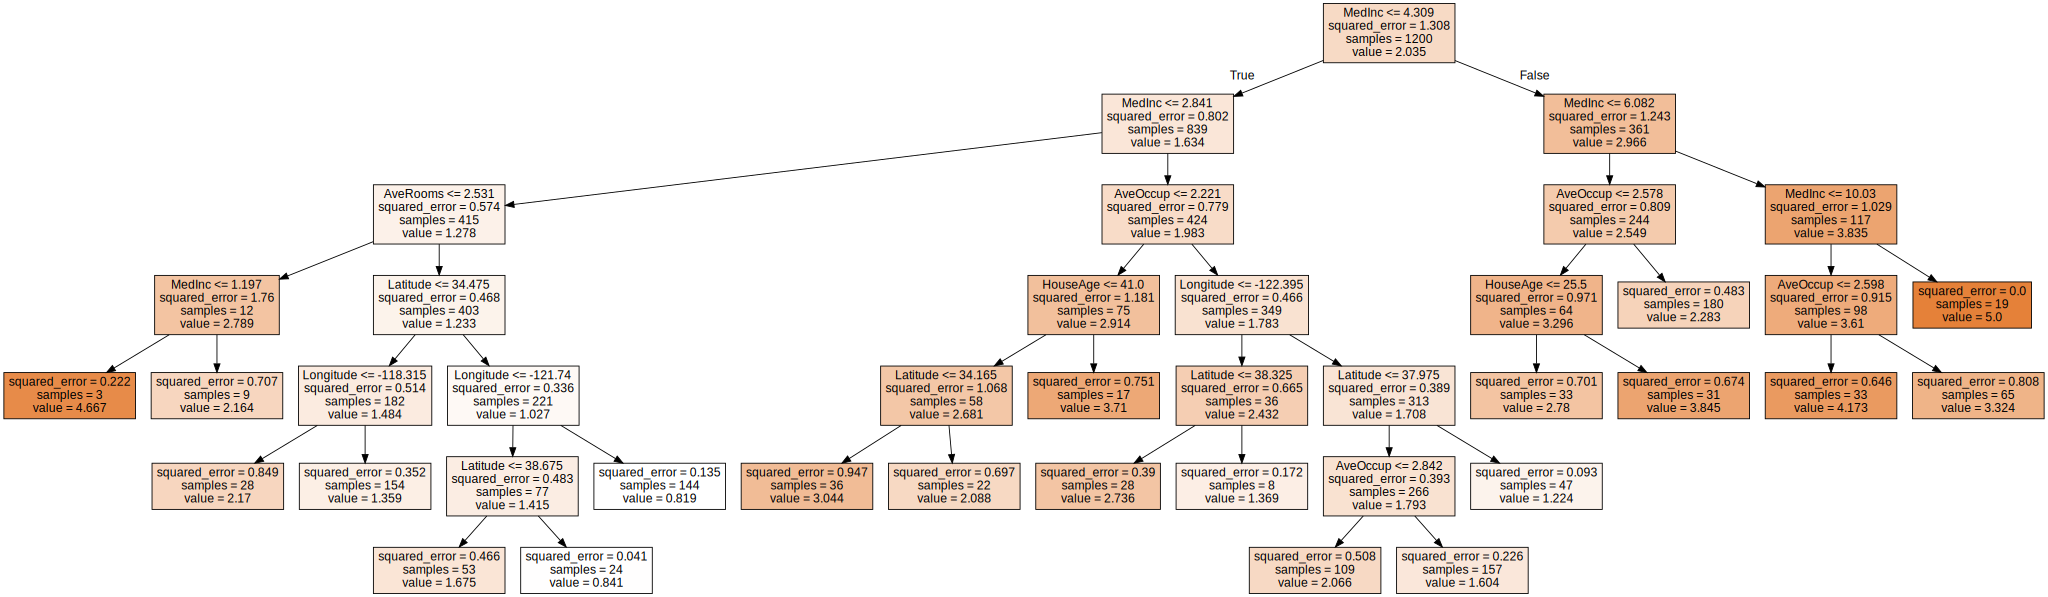

In [ ]:
# Визуализируйте дерево tree_housing_ccp

dot_data = tree.export_graphviz(tree_housing_ccp, out_file=None,
                                feature_names=X_housing_train.columns,
                                filled=True)
graphviz.Source(dot_data)

## **Предсказание временных рядов с помощью деревьев решений**

Деревья решений (и ансамбли на их основе) не могут быть использованы для прогнозирования временных рядом, содержащих тренд (долгосрочное возрастание или убывание значений), поскольку:

1. Дерево решений разбивает данные на основе признаков (например, год, месяц), но не учитывает их изменение со временем.

2. Если тренд сильный, дерево решений будет аппроксимировать его кусочно-линейными приближениями, что даст плохие прогнозы на новых данных.

3. Деревья не экстраполируют за пределы обучающей выборки: деревья не могут предсказать значения выше или ниже тех, что были использованы при обучении.

Одним из решений этой проблемы является переход от значений временного ряда с трендом к абсолютным приростам (разностям первого порядка):

$$\Delta y_{t}=y_{t}-y_{t-1}$$

где $y_{t}$ — истинное значение временного ряда в момент времени $t$.

После предсказания приростов $\Delta \hat{y_{t}}$​ можно восстановить исходный ряд:

$$\hat{y_{t}}=y_{0}+\sum_{i=1}^{t}{\Delta \hat{y_{t}}}$$

где $y_{0}$​ — начальное значение ряда.

Если прогноз выполняется рекурсивно (уже предсказанные значения используются для построения прогноза на следующие шаги), то возникает проблема накопления ошибок — ошибки суммируются на каждом шаге рекурсивного прогноза временного ряда. Это приведёт к тому, что итоговый прогноз $\hat{y_{t}}$ может значительно отклоняться от реальных значений временного ряда.

### **Датасет *Retail Sales: Restaurants and Other Eating Places***

**Для решения задания 4 рассмотрим датасет [Retail Sales: Restaurants and Other Eating Places](https://fred.stlouisfed.org/series/MRTSSM7225USN).**

**ВНИМАНИЕ:** При решении задания **используйте файл retail_sales.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Набор данных представляет собой временной ряд с ежемесячной частотой данных. Он предназначен для анализа тенденций и изменений в объёмах продаж в ресторанном бизнесе и сфере общественного питания в США.

Целевая переменная — RetailSales (совокупный ежемесячный объём продаж, млн. долларов США).

Рассмотрим период с января 1992 года по июнь 2019 года.

### ***Задание 4***

Используя значения ряда (RetailSales), создайте признаки:

* Лаговые признаки (*подсказка: используйте [shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)*):

    * lag 1m — значение RetailSales 1 месяц назад (временной лаг в 1 наблюдение).

    * lag 12m — значение RetailSales 12 месяцев назад (временной лаг в 12 наблюдений).

* Скользящее среднее (*подсказка: используйте признак **lag 1m** (скользящее среднее строится по **предыдущим** наблюдениям и не должно включать значение целевой переменной на момент прогноза) и [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)*):

    * mean 3m — среднее RetailSales за **предыдущие** 3 месяца (скользящее среднее по 3 **предыдущим** наблюдениям).

    * mean 12m — среднее RetailSales за **предыдущие** 12 месяцев (скользящее среднее по 12 **предыдущим** наблюдениям).

Используя метку времени (Date), создайте признаки:

* Временные компоненты:

    * day: число месяца.

    * month: месяц.

    * year: год.

* Циклические признаки, закодированные с помощью косинуса и синуса ($x_{\text{cos}} = \text{cos}(\frac{2 \pi x}{T})$, $x_{\text{sin}} = \text{sin}(\frac{2 \pi x}{T})$):

    * day_cos, day_sin: cos и sin от day ($T = 30$).

    * month_cos, month_sin: cos и sin от month ($T = 12$).

Разделите датасет на обучающую и тестовую выборки так, чтобы в обучающую выборку вошли все данные ранее 2016 года, в тестовую — все данные за 2016 год и позже.

Обучите дерево решений `tree_retail` (DecisionTreeRegressor) с ограничениями:

* min_samples_split=5.

* min_samples_leaf=2.

Используя данные после создания временных переменных и до разделения на обучающую и тестовую выборки (`X_retail`, `y_retail`), выделите новую объясняемую переменную `y_retail_diff` — абсолютные приросты значений временного ряда (**выполните переход от значений ряда к абсолютным приростам**), и **заново разделите датасет на обучающую и тестовую выборки** так, чтобы в обучающую выборку вошли все данные ранее 2016 года, в тестовую — все данные за 2016 год и позже.

Обучите дерево решений `tree_retail_diff` (DecisionTreeRegressor) с теми же ограничениями, что и у дерева `tree_retail`, в качестве **объясняемой переменной используя абсолютные приросты**.

Выведите metrics_report для моделей `tree_retail` и `tree_retail_diff` **на обучающей и тестовой выборке**.

**На тестовой выборке** преобразуйте предсказанные  моделью `tree_retail_diff` абсолютные приросты в исходные значения временного ряда и выведите metrics_report после обратного перехода к исходным значениям.

**ВНИМАНИЕ:** Обратите внимание, что в данном задании рассматривается упрощённый пример прогнозирования временного ряда на один временной период вперёд (на один месяц вперед). Для прогноза всегда используются истинные значения временных признаков, в том числе в рамках тестовой выборки. Таким образом, в данном примере модель не подвержена накоплению ошибки, поскольку такой прогноз не является рекурсивным.

In [ ]:
# Считайте набор данных

df_retail = pd.read_csv('retail.csv')
df_retail

,Date,RetailSales
0,1992-01-01,13130
1,1992-02-01,13276
2,1992-03-01,14135
3,1992-04-01,13858
4,1992-05-01,14854
...,...,...
325,2019-02-01,49162
326,2019-03-01,57230
327,2019-04-01,54723
328,2019-05-01,58681


In [ ]:
# Признак Date имеет тип данных object
# Необходимо изменить тип данных для Date

df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         330 non-null    object
 1   RetailSales  330 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [ ]:
# Измените тип Date на datetime64[ns]

df_retail['Date'] = pd.to_datetime(df_retail['Date'])

In [ ]:
# Убедитесь, что тип данных Date — datetime64[ns]

df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         330 non-null    datetime64[ns]
 1   RetailSales  330 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB


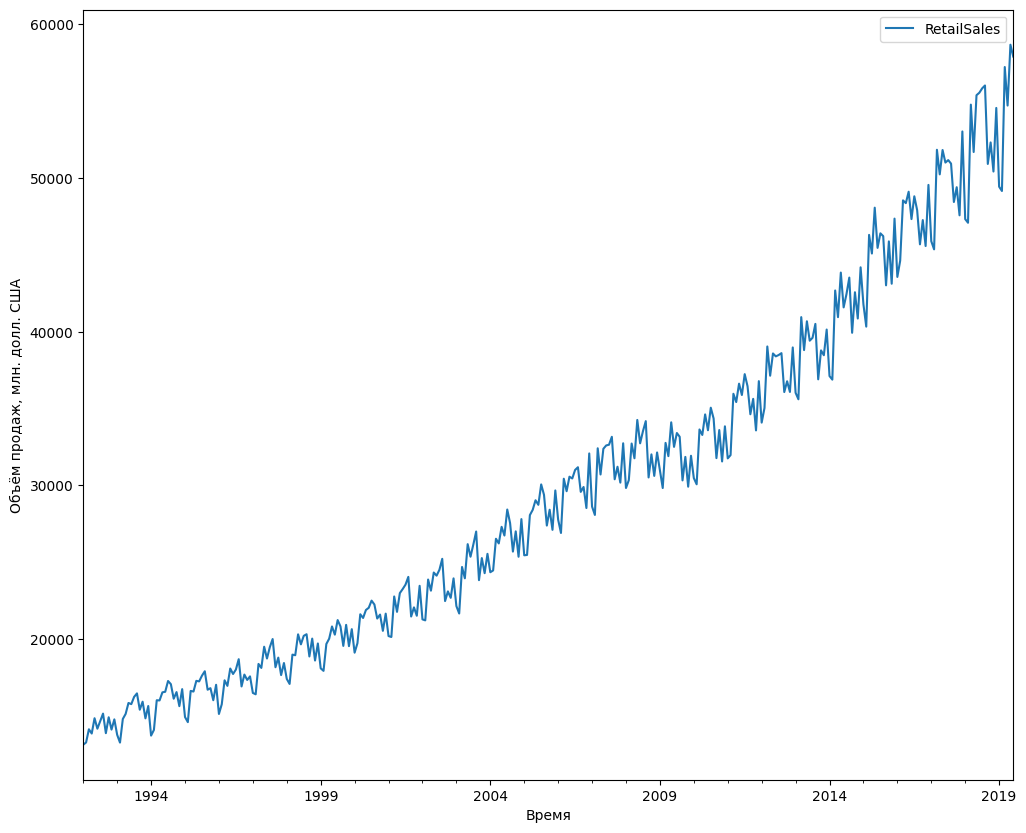

In [ ]:
# Постройте график значений временного ряда (RetailSales)

df_retail.plot(x='Date', y='RetailSales', figsize=(12, 10))
plt.xlabel('Время')
plt.ylabel('Объём продаж, млн. долл. США')
plt.show()

In [ ]:
# Создайте признаки lag 1m и lag 12m
# Подсказка: используйте shift

df_retail['lag 1m'] = df_retail['RetailSales'].shift(1)
df_retail['lag 12m'] = df_retail['RetailSales'].shift(12)

In [ ]:
# Создайте признаки mean 3m и mean 12m
# Подсказка: используйте признак lag 1m и rolling

df_retail['mean 3m'] = df_retail['lag 1m'].rolling(window=3).mean()
df_retail['mean 12m'] = df_retail['lag 1m'].rolling(window=12).mean()


In [ ]:
# Закодируйте метку времени (Date) как временные компоненты

df_retail['day'] = df_retail['Date'].dt.day
df_retail['month'] = df_retail['Date'].dt.month
df_retail['year'] = df_retail['Date'].dt.year

In [ ]:
# Закодируйте циклические переменные с помощью косинуса и синуса

df_retail['day_cos'] = np.cos(2*np.pi*df_retail['day']/30)
df_retail['day_sin'] = np.sin(2*np.pi*df_retail['day']/30)

df_retail['month_cos'] = np.cos(2*np.pi*df_retail['month']/12)
df_retail['month_sin'] = np.sin(2*np.pi*df_retail['month']/12)

In [ ]:
# Датасет после создания признаков

df_retail

,Date,RetailSales,lag 1m,lag 12m,mean 3m,mean 12m,day,month,year,day_cos,day_sin,month_cos,month_sin
0,1992-01-01,13130,NaN,NaN,NaN,NaN,1,1,1992,0.978148,0.207912,8.660254e-01,5.000000e-01
1,1992-02-01,13276,13130.0,NaN,NaN,NaN,1,2,1992,0.978148,0.207912,5.000000e-01,8.660254e-01
2,1992-03-01,14135,13276.0,NaN,NaN,NaN,1,3,1992,0.978148,0.207912,6.123234e-17,1.000000e+00
3,1992-04-01,13858,14135.0,NaN,13513.666667,NaN,1,4,1992,0.978148,0.207912,-5.000000e-01,8.660254e-01
4,1992-05-01,14854,13858.0,NaN,13756.333333,NaN,1,5,1992,0.978148,0.207912,-8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2019-02-01,49162,49445.0,47095.0,51480.333333,52840.250000,1,2,2019,0.978148,0.207912,5.000000e-01,8.660254e-01
326,2019-03-01,57230,49162.0,54782.0,51058.000000,53012.500000,1,3,2019,0.978148,0.207912,6.123234e-17,1.000000e+00
327,2019-04-01,54723,57230.0,51700.0,51945.666667,53216.500000,1,4,2019,0.978148,0.207912,-5.000000e-01,8.660254e-01
328,2019-05-01,58681,54723.0,55395.0,53705.000000,53468.416667,1,5,2019,0.978148,0.207912,-8.660254e-01,5.000000e-01


In [ ]:
# Удалите строки с пропущенными значениями
# Пропущенные значения появились после создания лаговых признаков и скользящих средних

df_retail = df_retail.dropna()

In [ ]:
# Установите метку времени (Date) как индекс датасета df_retail

df_retail = df_retail.set_index('Date', drop=True)

In [ ]:
# Выделите объясняемый фактор в отдельную переменную

X_retail, y_retail = df_retail.drop(columns=["RetailSales"]), df_retail['RetailSales']

In [ ]:
# Разделите датасет на обучающую и тестовую выборки:
#   Обучающая выборка — все данные ранее 2016 года
#   Тестовая выборка  — все данные за 2016 год и позже

mask = X_retail['year'] < 2016
X_retail_train = X_retail[mask]
y_retail_train = y_retail[mask]

X_retail_test = X_retail[~mask]
y_retail_test = y_retail[~mask]

In [ ]:
# На обучающей выборке обучите дерево решений tree_retail (DecisionTreeRegressor) с ограничениями:
#   min_samples_split=5
#   min_samples_leaf=2
# Не забудьте зафиксировать RANDOM_STATE

tree_retail = DecisionTreeRegressor(min_samples_split=5, min_samples_leaf=2, random_state=RANDOM_STATE)
tree_retail.fit(X_retail_train, y_retail_train)

DecisionTreeRegressor(min_samples_leaf=2, min_samples_split=5, random_state=42)

In [ ]:
# Выведите metrics_report для дерева tree_retail на обучающей и тестовой выборках

print("="*8,"train","="*8)
metrics_report(y_retail_train, tree_retail.predict(X_retail_train))
print("="*8,"test","="*8)
metrics_report(y_retail_test, tree_retail.predict(X_retail_test))

======== train ========
R2 score: 0.9989
RMSE: 292.6740
MAPE: 0.0073
======== test ========
R2 score: -0.4995
RMSE: 4633.2400
MAPE: 0.0640


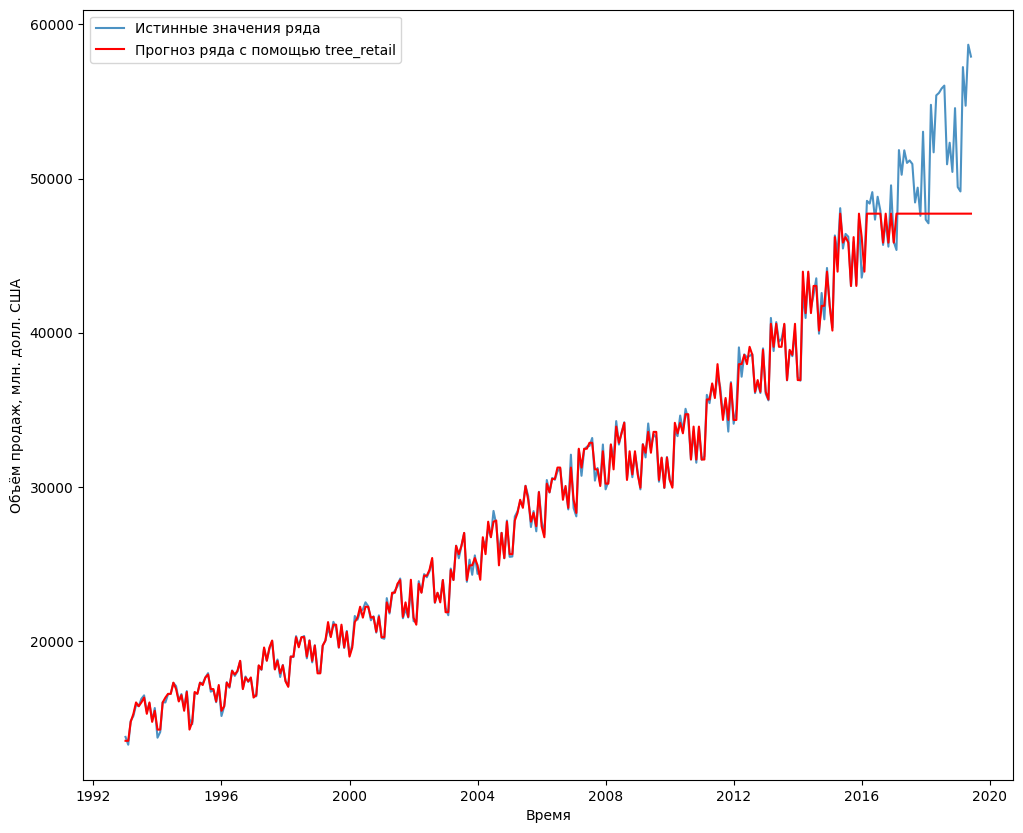

In [ ]:
# Постройте график значений временного ряда (RetailSales)
# Добавьте на график прогноз значений ряда моделью tree_retail

plt.figure(figsize=(12, 10))
plt.plot(X_retail.index, y_retail, alpha=0.8, label='Истинные значения ряда')
plt.plot(X_retail.index, tree_retail.predict(X_retail), c='red', label='Прогноз ряда с помощью tree_retail')
plt.xlabel('Время')
plt.ylabel('Объём продаж, млн. долл. США')
plt.legend()
plt.show()

In [ ]:
# Выделите новую объясняемую переменную y_retail_diff — абсолютные приросты значений временного ряда
# Подсказка: используйте shift

y_retail_diff = y_retail - y_retail.shift(1)
y_retail_diff = y_retail_diff[1:]
X_retail_diff = X_retail[1:]

In [ ]:
# Разделите датасет на обучающую и тестовую выборки:
#   Обучающая выборка — все данные ранее 2016 года
#   Тестовая выборка  — все данные за 2016 год и позже

X_retail_diff_train = X_retail_diff[mask]
y_retail_diff_train = y_retail_diff[mask]

X_retail_diff_test = X_retail_diff[~mask]
y_retail_diff_test = y_retail_diff[~mask]

In [ ]:
# На обучающей выборке обучите дерево tree_retail_diff (DecisionTreeRegressor) с ограничениями:
#   min_samples_split=5
#   min_samples_leaf=2
# В качестве объясняемой переменной используйте абсолютные приросты
# Не забудьте зафиксировать RANDOM_STATE

tree_retail_diff = DecisionTreeRegressor(min_samples_split=5, min_samples_leaf=2, random_state=RANDOM_STATE)
tree_retail_diff.fit(X_retail_diff_train, y_retail_diff_train)

DecisionTreeRegressor(min_samples_leaf=2, min_samples_split=5, random_state=42)

In [ ]:
# Выведите metrics_report для дерева tree_retail_diff на обучающей и тестовой выборках (в абсолютных приростах)

print("="*8,"train","="*8)
metrics_report(y_retail_diff_train, tree_retail_diff.predict(X_retail_diff_train))
print("="*8,"test","="*8)
metrics_report(y_retail_diff_test, tree_retail_diff.predict(X_retail_diff_test))

======== train ========
R2 score: 0.9729
RMSE: 279.9254
MAPE: 0.5546
======== test ========
R2 score: 0.8147
RMSE: 1394.2334
MAPE: 1.5168


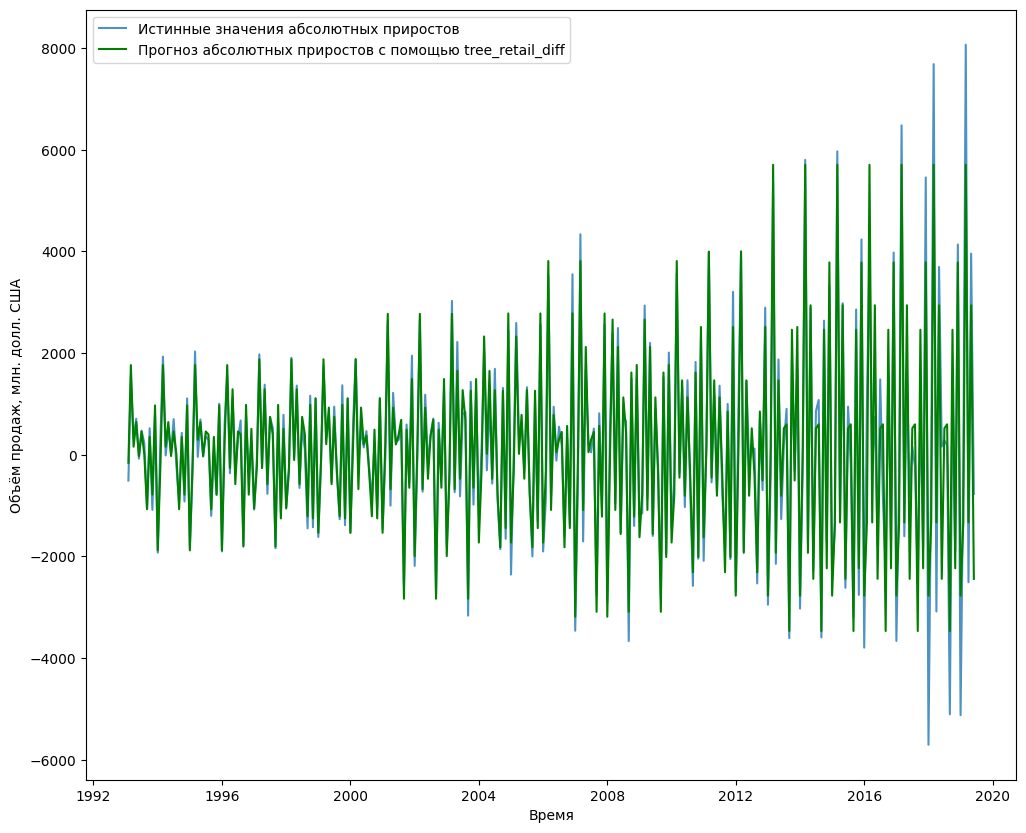

In [ ]:
# Постройте график значений абсолютных приростов
# Добавьте на график прогноз абсолютных приростов моделью tree_retail_diff

plt.figure(figsize=(12, 10))
plt.plot(X_retail_diff.index, y_retail_diff, alpha=0.8, label='Истинные значения абсолютных приростов')
plt.plot(X_retail_diff.index, tree_retail_diff.predict(X_retail_diff), c='green', label='Прогноз абсолютных приростов с помощью tree_retail_diff')
plt.xlabel('Время')
plt.ylabel('Объём продаж, млн. долл. США')
plt.legend()
plt.show()

In [ ]:
# На тестовой выборке преобразуйте предсказанные моделью tree_retail_diff абсолютные приросты в исходные значения временного ряда

y_test_pred_tree_retail_diff = y_retail_train[-1] + np.cumsum(tree_retail_diff.predict(X_retail_diff_test)) # В качестве y0 используем последнее истинное значение в train

In [ ]:
# Выведите metrics_report на тестовой выборке после обратного перехода от прогноза приростов к исходным значениям

metrics_report(y_retail_test, y_test_pred_tree_retail_diff)

R2 score: 0.9077
RMSE: 1149.5225
MAPE: 0.0181


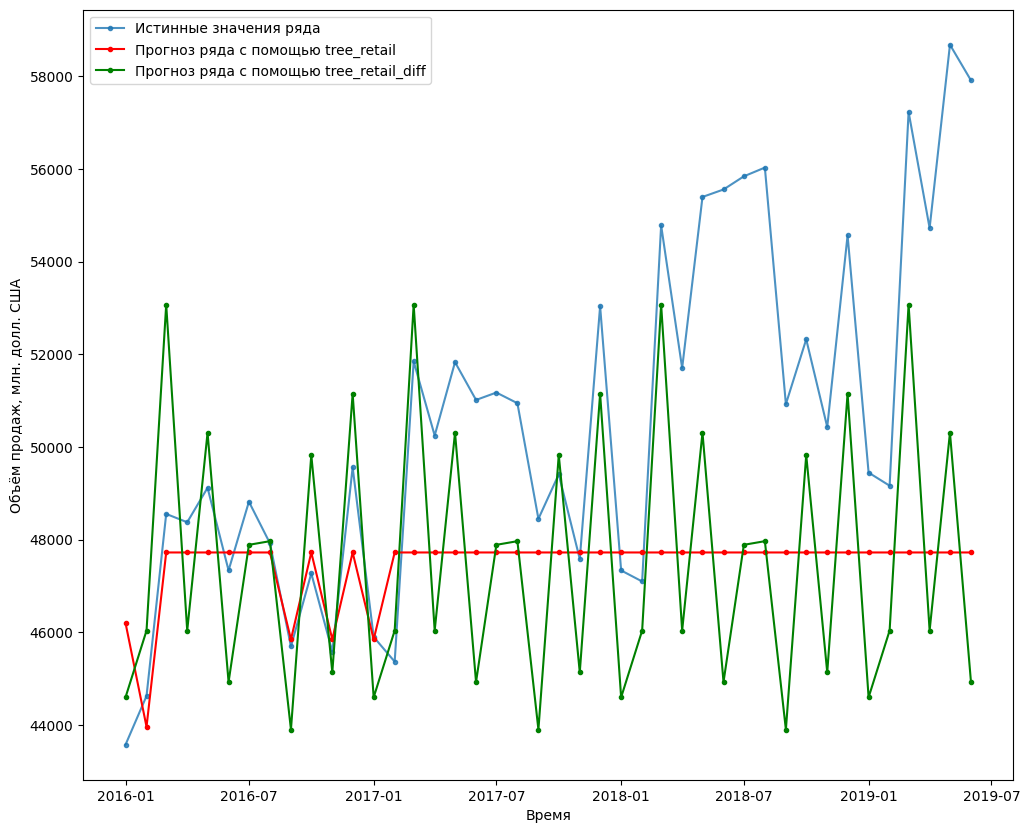

In [ ]:
# Постройте график значений временного ряда (RetailSales) на тестовой выборке
# Добавьте на график прогноз значений ряда с помощью моделей tree_retail и tree_retail_diff

plt.figure(figsize=(12, 10))
plt.plot(X_retail_test.index, y_retail_test, marker='.', alpha=0.8, label='Истинные значения ряда')
plt.plot(X_retail_test.index, tree_retail.predict(X_retail_test), marker='.', c='red', label='Прогноз ряда с помощью tree_retail')
plt.plot(X_retail_test.index, y_retail_train[-1] + tree_retail_diff.predict(X_retail_test), marker='.', c='green', label='Прогноз ряда с помощью tree_retail_diff')
plt.xlabel('Время')
plt.ylabel('Объём продаж, млн. долл. США')
plt.legend()
plt.show()